Removing weight norm...
Raw Text Sequence: It is a grest day today, but I do not know about tomorrow. Let us see
Phoneme Sequence: {IH0 T IH0 Z AH0 G R EH1 S T D EY1 T AH0 D EY1 sp B AH1 T AY1 D UW1 N AA1 T N OW1 AH0 B AW1 T T AH0 M AA1 R OW2 sp L EH1 T AH1 S S IY1}


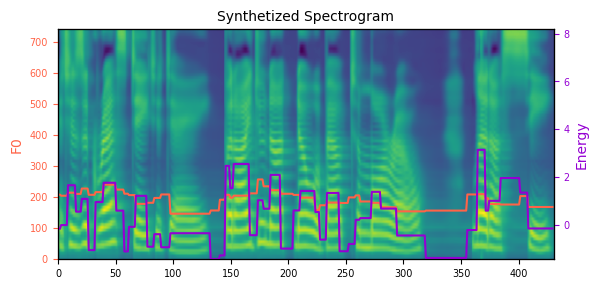

In [17]:
# need to install pytorch and the requirements:
# python3 -m pip install -r requirements.txt

import re
import argparse
from string import punctuation

import os
import torch
import json
import yaml
import numpy as np
from torch.utils.data import DataLoader
from g2p_en import G2p
from pypinyin import pinyin, Style
import IPython

from utils.model import get_model, get_vocoder, vocoder_infer
from utils.tools import to_device, synth_samples, plot_mel, expand
from dataset import TextDataset
from text import text_to_sequence
from model import FastSpeech2
from scipy.io import wavfile
from matplotlib import pyplot as plt
%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def read_lexicon(lex_path):
    lexicon = {}
    with open(lex_path) as f:
        for line in f:
            temp = re.split(r"\s+", line.strip("\n"))
            word = temp[0]
            phones = temp[1:]
            if word.lower() not in lexicon:
                lexicon[word.lower()] = phones
    return lexicon


def preprocess_english(text, preprocess_config):
    text = text.rstrip(punctuation)
    lexicon = read_lexicon(preprocess_config["path"]["lexicon_path"])

    g2p = G2p()
    phones = []
    words = re.split(r"([,;.\-\?\!\s+])", text)
    for w in words:
        if w.lower() in lexicon:
            phones += lexicon[w.lower()]
        else:
            phones += list(filter(lambda p: p != " ", g2p(w)))
    phones = "{" + "}{".join(phones) + "}"
    phones = re.sub(r"\{[^\w\s]?\}", "{sp}", phones)
    phones = phones.replace("}{", " ")

    print("Raw Text Sequence: {}".format(text))
    print("Phoneme Sequence: {}".format(phones))
    sequence = np.array(
        text_to_sequence(
            phones, preprocess_config["preprocessing"]["text"]["text_cleaners"]
        )
    )

    return np.array(sequence)


def preprocess_mandarin(text, preprocess_config):
    lexicon = read_lexicon(preprocess_config["path"]["lexicon_path"])

    phones = []
    pinyins = [
        p[0]
        for p in pinyin(
            text, style=Style.TONE3, strict=False, neutral_tone_with_five=True
        )
    ]
    for p in pinyins:
        if p in lexicon:
            phones += lexicon[p]
        else:
            phones.append("sp")

    phones = "{" + " ".join(phones) + "}"
    print("Raw Text Sequence: {}".format(text))
    print("Phoneme Sequence: {}".format(phones))
    sequence = np.array(
        text_to_sequence(
            phones, preprocess_config["preprocessing"]["text"]["text_cleaners"]
        )
    )

    return np.array(sequence)


config_path="config/LJSpeech"
args=dict(
    preprocess_config=os.path.join(config_path, "preprocess.yaml"),
    model_config=os.path.join(config_path, "model.yaml"),
    train_config=os.path.join(config_path, "train.yaml"),
    ckpt_name="900000.pth.tar",
)
pitch_control = 1.0
energy_control = 1.0
duration_control = 1.0

# Read Config
preprocess_config = yaml.load(
    open(args["preprocess_config"], "r"), Loader=yaml.FullLoader
)
model_config = yaml.load(open(args["model_config"], "r"), Loader=yaml.FullLoader)
train_config = yaml.load(open(args["train_config"], "r"), Loader=yaml.FullLoader)
configs = (preprocess_config, model_config, train_config)

# Get model
model = FastSpeech2(preprocess_config, model_config).to(device)

ckpt_path = os.path.join(
    train_config["path"]["ckpt_path"],
    args["ckpt_name"],
)
ckpt = torch.load(ckpt_path, map_location=device)
model.load_state_dict(ckpt["model"])

model.eval()
model.requires_grad_ = False


# Load vocoder
vocoder = get_vocoder(model_config, device)

# input_text = "Pittsburgh is a city of bridge." 
input_text="It is a grest day today, but I do not know about tomorrow. Let us see."
ids = raw_texts = [input_text[:100]]
speakers = np.array([0])
if preprocess_config["preprocessing"]["text"]["language"] == "en":
    texts = np.array([preprocess_english(input_text, preprocess_config)])
elif preprocess_config["preprocessing"]["text"]["language"] == "zh":
    texts = np.array([preprocess_mandarin(input_text, preprocess_config)])
text_lens = np.array([len(texts[0])])

targets = (ids, raw_texts, speakers, texts, text_lens, max(text_lens))

targets = to_device(targets, device)
with torch.no_grad():
    # Forward
    predictions = model(
        *(targets[2:]),
        p_control=pitch_control,
        e_control=energy_control,
        d_control=duration_control
    )    

# def synth_samples(targets, predictions, vocoder, model_config, preprocess_config, path):
    basenames = targets[0]
    for i in range(len(predictions[0])):
        basename = basenames[i]
        src_len = predictions[8][i].item()
        mel_len = predictions[9][i].item()
        mel_prediction = predictions[1][i, :mel_len].detach().transpose(0, 1)
        duration = predictions[5][i, :src_len].detach().cpu().numpy()
        if preprocess_config["preprocessing"]["pitch"]["feature"] == "phoneme_level":
            pitch = predictions[2][i, :src_len].detach().cpu().numpy()
            pitch = expand(pitch, duration)
        else:
            pitch = predictions[2][i, :mel_len].detach().cpu().numpy()
        if preprocess_config["preprocessing"]["energy"]["feature"] == "phoneme_level":
            energy = predictions[3][i, :src_len].detach().cpu().numpy()
            energy = expand(energy, duration)
        else:
            energy = predictions[3][i, :mel_len].detach().cpu().numpy()

        with open(
            os.path.join(preprocess_config["path"]["preprocessed_path"], "stats.json")
        ) as f:
            stats = json.load(f)
            stats = stats["pitch"] + stats["energy"][:2]

        fig = plot_mel(
            [
                (mel_prediction.cpu().numpy(), pitch, energy),
            ],
            stats,
            ["Synthetized Spectrogram"],
        )
        plt.show()

    mel_predictions = predictions[1].transpose(1, 2)
    lengths = predictions[9] * preprocess_config["preprocessing"]["stft"]["hop_length"]
    wav_predictions = vocoder_infer(
        mel_predictions, vocoder, model_config, preprocess_config, lengths=lengths
    )

    sampling_rate = preprocess_config["preprocessing"]["audio"]["sampling_rate"]
    for wav, basename in zip(wav_predictions, basenames):
        wavfile.write(os.path.join("output", "{}.wav".format(basename)), sampling_rate, wav)

IPython.display.Audio(wav_predictions[0], rate=sampling_rate)